Descripción de los datos

Cada entrada de registro es una acción de usuario o un evento.

    EventName: nombre del evento.
    DeviceIDHash: identificador de usuario unívoco.
    EventTimestamp: hora del evento.
    ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

Instrucciones para completar el proyecto

Paso 1. Abrir el archivo de datos y leer la información general

Ruta de archivo: */datasets/logs_exp_us.csv* 


In [2]:
# se importan las librerias necesarias para el analisis de datos
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt


def looks(datos):
    """Genera un análisis de todo el set de datos de manera global"""

    print("Se ejecuta la descripción de los datos:")
    print(datos.describe(include="all"))
    print()
    print("se hace exploración con método info:")
    print(datos.info())
    print()
    print("se hace una observación con el método Sample:")
    if len(datos) > 10:
        print(datos.sample(10))
    else:
        print(datos)
    print()
    print("hay NA?:")
    print(datos.isna().sum())
    print()
    print("Duplicados:")
    print(datos.duplicated().sum())

In [3]:
data = pd.read_csv('logs_exp_us.csv' , sep='\t')
looks(data)

Se ejecuta la descripción de los datos:
               EventName  DeviceIDHash  EventTimestamp          ExpId
count             244126  2.441260e+05    2.441260e+05  244126.000000
unique                 5           NaN             NaN            NaN
top     MainScreenAppear           NaN             NaN            NaN
freq              119205           NaN             NaN            NaN
mean                 NaN  4.627568e+18    1.564914e+09     247.022296
std                  NaN  2.642425e+18    1.771343e+05       0.824434
min                  NaN  6.888747e+15    1.564030e+09     246.000000
25%                  NaN  2.372212e+18    1.564757e+09     246.000000
50%                  NaN  4.623192e+18    1.564919e+09     247.000000
75%                  NaN  6.932517e+18    1.565075e+09     248.000000
max                  NaN  9.222603e+18    1.565213e+09     248.000000

se hace exploración con método info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data

In [4]:
#Se exploran los duplicados para ver si hay duplicados reales, Se determina que no, solo son distintos eventos para el mismo dispositivo, o el mismo evento para distintos dispositivos
print(data[data.duplicated()].sort_values('DeviceIDHash').head(15))

                      EventName        DeviceIDHash  EventTimestamp  ExpId
130558         MainScreenAppear   33176906322804559      1564933075    248
130995       OffersScreenAppear   33176906322804559      1564933763    248
104108         CartScreenAppear   34565258828294726      1564857221    248
159302  PaymentScreenSuccessful   54903596035630984      1565011672    248
176813  PaymentScreenSuccessful   77364241990273403      1565044732    246
189896         MainScreenAppear   91292479590032512      1565087723    246
155464         MainScreenAppear   95206628315371849      1565005724    247
110479         MainScreenAppear  170935625628929269      1564897487    246
34223          CartScreenAppear  197027893265565660      1564684544    246
17037          CartScreenAppear  197027893265565660      1564659614    246
112562         CartScreenAppear  197027893265565660      1564902904    246
144045         CartScreenAppear  197027893265565660      1564983860    246
23421          CartScreen


Paso 2. Preparar los datos para el análisis

    Cambia el nombre de las columnas de manera que sea conveniente para ti.
    Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.
    Agrega una columna de fecha y hora y una columna separada para las fechas.

In [5]:
data['daytime'] = data['EventTimestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
data['date'] = data['daytime'].dt.date
data

,EventName,DeviceIDHash,EventTimestamp,ExpId,daytime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-24 23:43:36,2019-07-24
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 06:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 06:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 06:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 06:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 16:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 16:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 16:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 16:14:58,2019-08-07




Paso 3. Estudiar y comprobar los datos

  -  ¿Cuántos eventos hay en los registros?
  -  ¿Cuántos usuarios hay en los registros?
  -  ¿Cuál es el promedio de eventos por usuario?
  -  ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
  -  ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
  -  Asegúrate de tener usuarios de los tres grupos experimentales.


In [21]:
# ¿Cuántos eventos hay en los registros?
print('Nombres de los eventos:')
for event in data['EventName'].unique(): print(event)
print()
print('Número de eventos:',len(data['EventName'].unique()))

Nombres de los eventos:
MainScreenAppear
PaymentScreenSuccessful
CartScreenAppear
OffersScreenAppear
Tutorial

Número de eventos: 5


In [23]:
# ¿Cuántos usuarios hay en los registros?

print('Número de Usuarios:', len(data['DeviceIDHash'].unique()))

Número de Usuarios: 7551


In [27]:
# ¿Cuál es el promedio de eventos por usuario?

data.groupby('DeviceIDHash')['EventName'].count().mean()

np.float64(32.33028737915508)

Fecha mínima: 2019-07-24 23:43:36
Fecha máxima: 2019-08-07 16:15:17


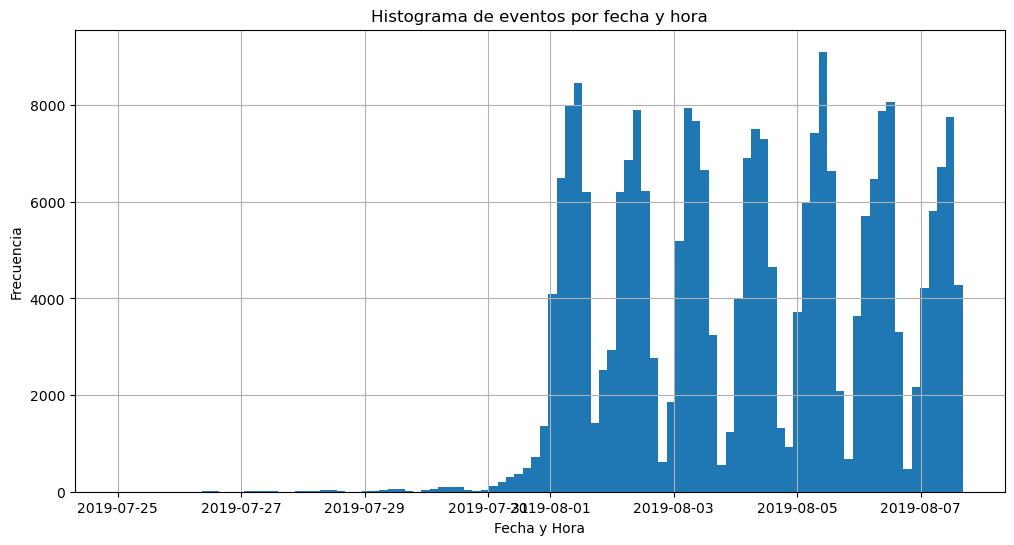

In [30]:
 # ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. 
print(f"Fecha mínima: {data['daytime'].min()}")
print(f"Fecha máxima: {data['daytime'].max()}")

# Traza un histograma por fecha y hora
plt.figure(figsize=(12, 6))
data['daytime'].hist(bins=100)
plt.xlabel('Fecha y Hora')
plt.ylabel('Frecuencia')
plt.title('Histograma de eventos por fecha')
plt.show()

In [ ]:
 # ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. 

 # Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. 
 # ¿Qué periodo representan realmente los datos?


Paso 4. Estudiar el embudo de eventos

    Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
    Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.
    ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
    Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.
    ¿En qué etapa pierdes más usuarios?
    ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?



Paso 5. Estudiar los resultados del experimento

    ¿Cuántos usuarios hay en cada grupo?
    Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
    Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?
    Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
    ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.